In [61]:
import os
import sys
sys.path.append("../")
import csv
import json
from datetime import datetime, timedelta
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score, precision_score, recall_score, confusion_matrix
import seaborn as sns

import settings
from prediction_dataset import PredictionDataset
from process_sentinel3 import OLCIdataGenerator

In [62]:
processed_data_path = settings.processed_data_path

DATE_FORMAT = '%Y-%m-%d'

ndci_data_path = os.path.join(settings.final_data_path, "kmeans_3", "ndci_data.csv")
precipitation_data_path = os.path.join(settings.final_data_path, "precipitation", "precipitation.csv")
wind_data_path = os.path.join(settings.final_data_path, "wind_data.csv")
water_temperature_data_path = os.path.join(settings.final_data_path, "water_temperature.csv")
algae_gt_path = os.path.join(settings.final_data_path, "algae_gt.csv")
ta_ose_path = os.path.join(settings.final_data_path, "agua_open_data(1).csv")
s3_brrs_path = os.path.join(settings.final_data_path, "s3_brrs.json")

raw_cyano_gt_path = os.path.join(settings.final_data_path, "MUESTREOS_SEMANALES_2016-2017-2018-2019-2020.xls")

bloom_thresholds = {
                    "MALLORQUINA":7000,
                    "ARROYO SAUCE": 7000,
                    "SAUCE NORTE": 7000,
                    "SAUCE SUR": 7000,
                    "CISNES": 7000,
                    "POTRERO": 7000,
                    "TA":3000
                   }

sampling_points_coords = {"SAUCE NORTE": [-34.795398, -55.047355],
                          "SAUCE SUR": [-34.843127, -55.064624],
                          "TA": [-34.829670, -55.049758]}

In [4]:
dataset = PredictionDataset(wind_data_path, water_temperature_data_path, precipitation_data_path, 
                            ndci_data_path, algae_gt_path, s3_brrs_path, bloom_thresholds=bloom_thresholds)

../prediction_dataset.py:156: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  location_data_df["label"] = days_before_bloom_col


In [7]:
def metrics(gt, pred, labels=["No Bloom", "Bloom"]):
    metrics = {}
    metrics["accuracy"] = round(accuracy_score(gt, pred), 2)
    metrics["precision"] = round(precision_score(gt, pred, pos_label=labels[1]), 2)
    metrics["recall"] = round(recall_score(gt, pred, pos_label=labels[1]), 2)
    metrics["confusion matrix"] = confusion_matrix(gt, pred, labels=labels)
    metrics["false positive rate"] = round(metrics["confusion matrix"][1, 0]/(metrics["confusion matrix"][1, 1] + metrics["confusion matrix"][1, 0]), 2)
    metrics["false negative rate"] = round(metrics["confusion matrix"][0, 1]/(metrics["confusion matrix"][0, 0] + metrics["confusion matrix"][0, 1]), 2)
    
    return metrics

## Blooming detection with MPH

In [5]:
# create generator that yields instances of OLCIdata from dates with ground truth
# data corrupted by clouds is skipped
data_generator = OLCIdataGenerator(processed_data_path, DATE_FORMAT, skip_invalid=True)

y_gt = {"SAUCE NORTE": [],
        "SAUCE SUR": [],
        "TA": []}

y_pred = {"SAUCE NORTE": [],
        "SAUCE SUR": [],
        "TA": []}

predicted_dates = {"SAUCE NORTE": [],
                    "SAUCE SUR": [],
                    "TA": []}

for olci_data in data_generator:
    # get gt data for same date as OLCI data
    day_fico_df = dataset.algae_gt[dataset.algae_gt["date"] == olci_data.date.date()]
    # iterate over rows, skipping unwanted gt data
    for index, row in day_fico_df.iterrows():
        if not (row["location"] in y_gt):
            continue
            
        olci_data.create_sparse_mask([sampling_points_coords[row["location"]]])
        
        immersed_mask = olci_data.mph.immersed_cyanobacteria*olci_data.mask
        count_immersed = np.count_nonzero(immersed_mask)
        
        floating_mask = olci_data.mph.floating_cyanobacteria*olci_data.mask
        count_floating = np.count_nonzero(olci_data.mph.floating_cyanobacteria*olci_data.mask)
        
        count_total = count_immersed + count_floating

        y_pred[row["location"]].append("Bloom" if count_total > 0 else "No Bloom")
        y_gt[row["location"]].append(row["label"])
        predicted_dates[row["location"]].append(olci_data.date)

SAUCE NORTE
Accuracy: 0.85
Precision: 0.6
Recall: 1.0
FPR: 0.0
FNR: 0.2


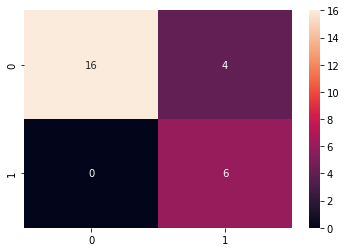

SAUCE SUR
Accuracy: 0.88
Precision: 0.73
Recall: 1.0
FPR: 0.0
FNR: 0.17


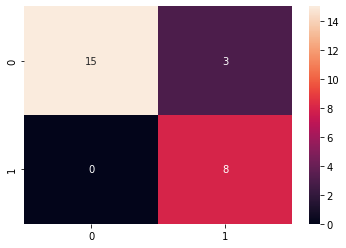

TA
Accuracy: 0.86
Precision: 0.77
Recall: 1.0
FPR: 0.0
FNR: 0.26


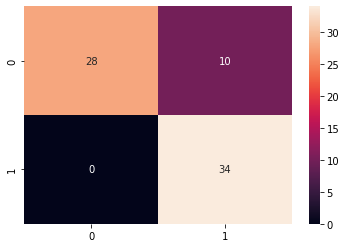

In [6]:
for location in list(y_gt.keys()):
    print(location)
    m = metrics(y_gt[location], y_pred[location])
    print("Accuracy:", m["accuracy"])
    print("Precision:", m["precision"])
    print("Recall:", m["recall"])
    print("FPR:", m["false positive rate"])
    print("FNR:", m["false negative rate"])
    sns.heatmap(m["confusion matrix"], annot=True)
    plt.show()

## Bloom detection using MPH + rain, temperature and wind

In [7]:
dataset.algae_gt

,date,location,fico,chl,label
0,2015-12-30,MALLORQUINA,5032.50,10.00,No Bloom
1,2015-12-30,ARROYO SAUCE,5345.50,21.80,No Bloom
2,2015-12-30,SAUCE NORTE,4282.50,7.50,No Bloom
3,2015-12-30,SAUCE SUR,5388.00,7.50,No Bloom
4,2015-12-30,CISNES,9082.50,18.45,Bloom
...,...,...,...,...,...
685,2020-10-31,TA,1083.00,NaN,No Bloom
686,2020-11-01,TA,47.00,NaN,No Bloom
687,2020-11-02,TA,5.96,NaN,No Bloom
688,2020-11-05,TA,9.06,NaN,No Bloom


In [8]:
sample_date = datetime(2020, 12, 1)
dataset.get_historic_data(sample_date, 5)[["date", "wind", "temperature", "precipitation"]]

,date,wind,temperature,precipitation
0,2020-12-01,4.5,17.0,0.00
1,2020-11-30,14.5,17.0,0.00
2,2020-11-29,13.5,21.0,3.51
3,2020-11-28,12.0,21.5,6.78
4,2020-11-27,9.0,18.0,0.00


### Measure correlations

In [9]:
from collections import defaultdict

infinite_defaultdict = lambda: defaultdict(infinite_defaultdict)
correlations = infinite_defaultdict() 

accumulation_methods = ["sum", "min", "max", "mean"]
# try to find correlations accumulating data from 1 to 9 days before the dates with GT
for days_before in range(1, 10, 1):
    accumulation_data = []
    for index, row in dataset.algae_gt.iterrows():
        if row["location"] not in ["SAUCE NORTE", "SAUCE SUR", "TA"]:
            continue

        row_date = datetime(row["date"].year, row["date"].month, row["date"].day, 0, 0, 0)
        historic_data = dataset.get_historic_data(row_date, days_before)

        if len(historic_data) == 0: continue

        item = {"date": row["date"], "label": row["label"]}
        for m in accumulation_methods:
            item["precipitation_" + m] = getattr(historic_data["precipitation"], m)()
            item["temperature_" + m] = getattr(historic_data["temperature"], m)()
            item["wind_" + m] = getattr(historic_data["wind"], m)()
        accumulation_data.append(item)
    
    accumulation_df = pd.DataFrame(accumulation_data)
    accumulation_df = accumulation_df[accumulation_df["date"] >= datetime(2018, 11, 1, 0, 0).date()]
    accumulation_df["numeric label"] = accumulation_df["label"].replace("No Bloom", 0)
    accumulation_df["numeric label"] = accumulation_df["numeric label"].replace("Bloom", 1)
    
    print(f"{days_before} days accumulation")
    for d in ["precipitation", "temperature", "wind"]:
        for m in accumulation_methods:
            accumulation_dataname = f"{d}_{m}"
            accumulation_correlation = accumulation_df['numeric label'].corr(accumulation_df[accumulation_dataname])
            print(f"{accumulation_dataname} ----> {accumulation_correlation}")
            correlations[d][days_before][m] = accumulation_correlation
    print("////////////")

1 days accumulation
precipitation_sum ----> -0.01874771406542977
precipitation_min ----> -0.0007145091478845336
precipitation_max ----> -0.0007145091478845336
precipitation_mean ----> -0.0007145091478845336
temperature_sum ----> -0.2852300932690982
temperature_min ----> -0.2852300932690982
temperature_max ----> -0.2852300932690982
temperature_mean ----> -0.2852300932690982
wind_sum ----> 0.08200468747022889
wind_min ----> 0.08200468747022889
wind_max ----> 0.08200468747022889
wind_mean ----> 0.08200468747022889
////////////
2 days accumulation
precipitation_sum ----> -0.07340505922413579
precipitation_min ----> 0.040011605972809026
precipitation_max ----> -0.08330499695641451
precipitation_mean ----> -0.05959169987648199
temperature_sum ----> -0.29060607532422444
temperature_min ----> -0.2822980383852778
temperature_max ----> -0.2906992382141217
temperature_mean ----> -0.29060607532422444
wind_sum ----> 0.07780353920733676
wind_min ----> 0.0203439511175491
wind_max ----> 0.110336387419

In [10]:
accumulation_df

,date,label,precipitation_sum,temperature_sum,wind_sum,precipitation_min,temperature_min,wind_min,precipitation_max,temperature_max,wind_max,precipitation_mean,temperature_mean,wind_mean,numeric label
92,2018-11-13,No Bloom,149.440001,179.5,80.5,0.0,17.5,5.5,73.440002,22.5,11.5,16.604445,19.944444,8.944444,0
93,2018-11-13,No Bloom,149.440001,179.5,80.5,0.0,17.5,5.5,73.440002,22.5,11.5,16.604445,19.944444,8.944444,0
94,2018-11-20,No Bloom,39.560000,170.0,120.5,0.0,15.5,7.5,26.469999,21.0,20.5,4.395556,18.888889,13.388889,0
95,2018-11-20,No Bloom,39.560000,170.0,120.5,0.0,15.5,7.5,26.469999,21.0,20.5,4.395556,18.888889,13.388889,0
96,2018-11-30,No Bloom,8.780000,171.0,108.5,0.0,16.0,4.5,4.080000,24.0,17.5,0.975556,19.000000,12.055556,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
348,2020-10-31,No Bloom,13.800000,135.0,90.0,0.0,11.5,5.5,8.770000,20.0,19.0,1.533333,15.000000,10.000000,0
349,2020-11-01,No Bloom,5.030000,132.0,90.0,0.0,11.5,5.5,3.290000,20.0,19.0,0.558889,14.666667,10.000000,0
350,2020-11-02,No Bloom,5.030000,128.5,89.5,0.0,11.5,5.0,3.290000,20.0,19.0,0.558889,14.277778,9.944444,0
351,2020-11-05,No Bloom,0.000000,124.0,75.0,0.0,11.5,5.0,0.000000,16.0,15.0,0.000000,13.777778,8.333333,0


### Find best correlations

In [13]:
for data_type in correlations.keys():
    print(data_type)
    correlations_df = pd.DataFrame(correlations[data_type])
    
    max_corr = correlations_df.max().max()
    min_corr = correlations_df.min().min()
    
    max_correlation = correlations_df.where(correlations_df==max_corr).dropna(how='all').dropna(axis=1)
    min_correlation = correlations_df.where(correlations_df==min_corr).dropna(how='all').dropna(axis=1)
    
    print(f"{max_correlation.columns.tolist()} days accumulated with {str(max_correlation.index.tolist())}: {max_corr}")
    print()
    print(f"{min_correlation.columns.tolist()} days accumulated with {min_correlation.index.tolist()}: {min_corr}")
    
    print("/////////////////////////////")
    

precipitation
[2] days accumulated with ['min']: 0.040011605972809026

[4] days accumulated with ['sum']: -0.16916844622447247
/////////////////////////////
temperature
[8] days accumulated with ['min']: -0.2200104598667602

[9] days accumulated with ['max']: -0.38011474682735324
/////////////////////////////
wind
[9] days accumulated with ['max']: 0.4974825722534988

[8] days accumulated with ['min']: -0.11175313149023809
/////////////////////////////


## Prediction with MPH indexes

In [20]:
data_generator = OLCIdataGenerator(processed_data_path, DATE_FORMAT, skip_invalid=True)

X = []
y = []
dates_list = []

for olci_data in data_generator:
    # get gt data for same date as OLCI data
    day_fico_df = dataset.algae_gt[dataset.algae_gt["date"] == olci_data.date.date()]
    # iterate over rows, skipping unwanted gt data
    for index, row in day_fico_df.iterrows():
        if not (row["location"] in ["SAUCE NORTE", "SAUCE SUR", "TA"]):
            continue
            
        dates_list.append(row["date"])
            
        y.append(row["label"])
        
        location_coords = sampling_points_coords[row["location"]]
        
        i, j = olci_data.get_pos_index(location_coords[0], location_coords[1])
        
        #get a 3x3 grid centered on the sampling location
        NDVI = olci_data.mph.NDVI[i-1:i+2, j-1:j+2].mean()
        BAIR = olci_data.mph.BAIR[i-1:i+2, j-1:j+2].mean()
        SICF = olci_data.mph.SICF[i-1:i+2, j-1:j+2].mean()
        SIPF = olci_data.mph.SIPF[i-1:i+2, j-1:j+2].mean()
        MPH0 = olci_data.mph.MPH0[i-1:i+2, j-1:j+2].mean()
        MPH1 = olci_data.mph.MPH1[i-1:i+2, j-1:j+2].mean()
        lambda_max1 = olci_data.mph.lambda_max1[i-1:i+2, j-1:j+2].max()
        
#         NDVI = olci_data.mph.NDVI[i-1:i+2, j-1:j+2].min()
#         BAIR = olci_data.mph.BAIR[i-1:i+2, j-1:j+2].min()
#         SICF = olci_data.mph.SICF[i-1:i+2, j-1:j+2].min()
#         SIPF = olci_data.mph.SIPF[i-1:i+2, j-1:j+2].min()
#         MPH0 = olci_data.mph.MPH0[i-1:i+2, j-1:j+2].min()
#         MPH1 = olci_data.mph.MPH1[i-1:i+2, j-1:j+2].min()
#         lambda_max1 = olci_data.mph.lambda_max1[i-1:i+2, j-1:j+2].min()

#         NDVI = olci_data.mph.NDVI[i, j]
#         BAIR = olci_data.mph.BAIR[i, j]
#         SICF = olci_data.mph.SICF[i, j]
#         SIPF = olci_data.mph.SIPF[i, j]
#         MPH0 = olci_data.mph.MPH0[i, j]
#         MPH1 = olci_data.mph.MPH1[i, j]
#         lambda_max1 = olci_data.mph.lambda_max1[i, j]
        
#         NDVI = olci_data.mph.NDVI[i-1:i+2, j-1:j+2].max()
#         BAIR = olci_data.mph.BAIR[i-1:i+2, j-1:j+2].max()
#         SICF = olci_data.mph.SICF[i-1:i+2, j-1:j+2].max()
#         SIPF = olci_data.mph.SIPF[i-1:i+2, j-1:j+2].max()
#         MPH0 = olci_data.mph.MPH0[i-1:i+2, j-1:j+2].max()
#         MPH1 = olci_data.mph.MPH1[i-1:i+2, j-1:j+2].max()
#         lambda_max1 = olci_data.mph.lambda_max1[i-1:i+2, j-1:j+2].max()
        
        X.append([NDVI, BAIR, SICF, SIPF, MPH0, MPH1, lambda_max1])
X = np.array(X)
y = np.array(y)

DecisionTreeClassifier(max_depth=3, random_state=0)
Accuracy: 0.89
Precision: 0.8
Recall: 0.94
FPR: 0.06
FNR: 0.14


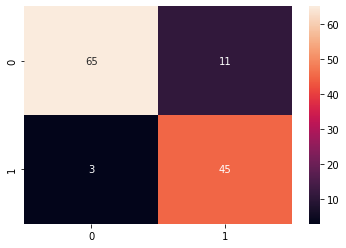

LogisticRegression()
Accuracy: 0.6
Precision: 0.0
Recall: 0.0
FPR: 1.0
FNR: 0.01


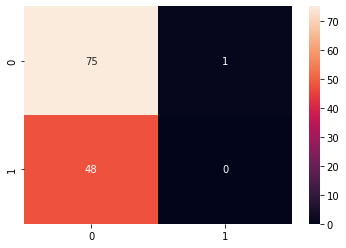

Pipeline(steps=[('standardscaler', StandardScaler()),
                ('svc', SVC(gamma='auto'))])
Accuracy: 0.94
Precision: 0.87
Recall: 0.98
FPR: 0.02
FNR: 0.09


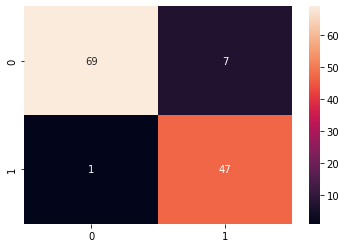

GaussianNB()
Accuracy: 0.9
Precision: 0.8
Recall: 1.0
FPR: 0.0
FNR: 0.16


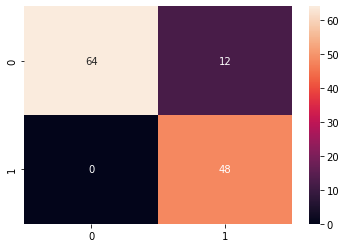

Pipeline(steps=[('standardscaler', StandardScaler()),
                ('sgdclassifier', SGDClassifier())])
Accuracy: 0.89
Precision: 0.85
Recall: 0.85
FPR: 0.15
FNR: 0.09


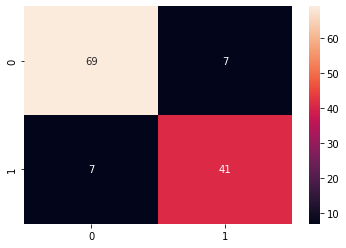

KNeighborsClassifier()
Accuracy: 0.8
Precision: 0.72
Recall: 0.79
FPR: 0.21
FNR: 0.2


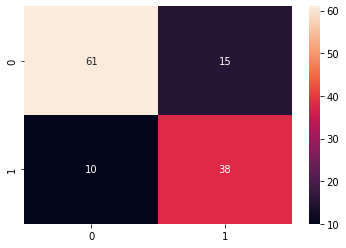

RandomForestClassifier(max_depth=3, random_state=0)
Accuracy: 0.93
Precision: 0.87
Recall: 0.96
FPR: 0.04
FNR: 0.09


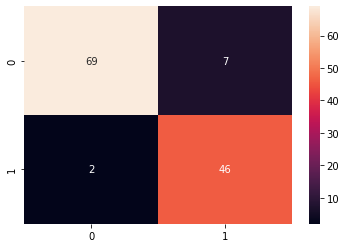

GradientBoostingClassifier(learning_rate=1.0, max_depth=1, random_state=0)
Accuracy: 0.92
Precision: 0.88
Recall: 0.92
FPR: 0.08
FNR: 0.08


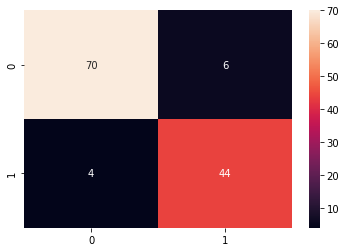

LGBMClassifier()
Accuracy: 0.91
Precision: 0.86
Recall: 0.92
FPR: 0.08
FNR: 0.09


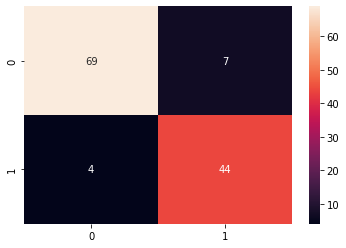

XGBClassifier(base_score=None, booster=None, colsample_bylevel=None,
              colsample_bynode=None, colsample_bytree=None,
              enable_categorical=False, gamma=None, gpu_id=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=None, max_delta_step=None, max_depth=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              n_estimators=100, n_jobs=None, num_parallel_tree=None,
              predictor=None, random_state=None, reg_alpha=None,
              reg_lambda=None, scale_pos_weight=None, subsample=None,
              tree_method=None, validate_parameters=None, verbosity=0)


/home/enzo/anaconda3/envs/cyano_venv/lib/python3.6/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


Accuracy: 0.91
Precision: 0.86
Recall: 0.92
FPR: 0.08
FNR: 0.09


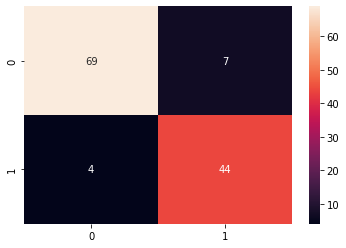

In [9]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.naive_bayes import GaussianNB
#from sklearn.naive_bayes import MultinomialNB ValueError: Negative values in data passed to MultinomialNB (input X)
from sklearn.linear_model import SGDClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier
from lightgbm import LGBMClassifier
from xgboost.sklearn import XGBClassifier

from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler

from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import LeaveOneOut

clfs = [DecisionTreeClassifier(random_state=0, max_depth=3),
        LogisticRegression(),
        make_pipeline(StandardScaler(), SVC(gamma='auto')),
        GaussianNB(),
        make_pipeline(StandardScaler(), SGDClassifier(max_iter=1000, tol=1e-3)),
        KNeighborsClassifier(n_neighbors=5),
        RandomForestClassifier(max_depth=3, random_state=0),
        GradientBoostingClassifier(n_estimators=100, learning_rate=1.0, max_depth=1, random_state=0),
        LGBMClassifier(),
        XGBClassifier(verbosity=0)]
        
        
#cv = StratifiedKFold(n_splits=2)
cv = LeaveOneOut()
for clf in clfs:
    print(clf)
    y_test_all = []
    y_pred_all = []
    for train_index, test_index in cv.split(X, y):
        X_train, X_test = X[train_index], X[test_index]
        y_train, y_test = y[train_index], y[test_index]

        clf.fit(X_train, y_train)

        y_pred = clf.predict(X_test)

        y_test_all.append(y_test[0])
        y_pred_all.append(y_pred[0])

    #     m = metrics(y_test, y_pred)
    #     print("Accuracy:", m["accuracy"])
    #     print("Precision:", m["precision"])
    #     print("Recall:", m["recall"])
    #     print("FPR:", m["false positive rate"])
    #     print("FNR:", m["false negative rate"])
    #     sns.heatmap(m["confusion matrix"], annot=True)
    #     plt.show()

    m = metrics(y_test_all, y_pred_all)
    print("Accuracy:", m["accuracy"])
    print("Precision:", m["precision"])
    print("Recall:", m["recall"])
    print("FPR:", m["false positive rate"])
    print("FNR:", m["false negative rate"])
    sns.heatmap(m["confusion matrix"], annot=True)
    plt.show()
        


[Text(186.0, 475.65000000000003, 'MPH0 <= 0.007\ngini = 0.475\nsamples = 124\nvalue = [48, 76]\nclass = Bloom'),
 Text(93.0, 339.75, 'gini = 0.0\nsamples = 68\nvalue = [0, 68]\nclass = Bloom'),
 Text(279.0, 339.75, 'SIPF <= -0.0\ngini = 0.245\nsamples = 56\nvalue = [48, 8]\nclass = No Bloom'),
 Text(186.0, 203.85000000000002, 'gini = 0.0\nsamples = 2\nvalue = [0, 2]\nclass = Bloom'),
 Text(372.0, 203.85000000000002, 'SICF <= -0.007\ngini = 0.198\nsamples = 54\nvalue = [48, 6]\nclass = No Bloom'),
 Text(279.0, 67.94999999999999, 'gini = 0.0\nsamples = 29\nvalue = [29, 0]\nclass = No Bloom'),
 Text(465.0, 67.94999999999999, 'gini = 0.365\nsamples = 25\nvalue = [19, 6]\nclass = No Bloom')]

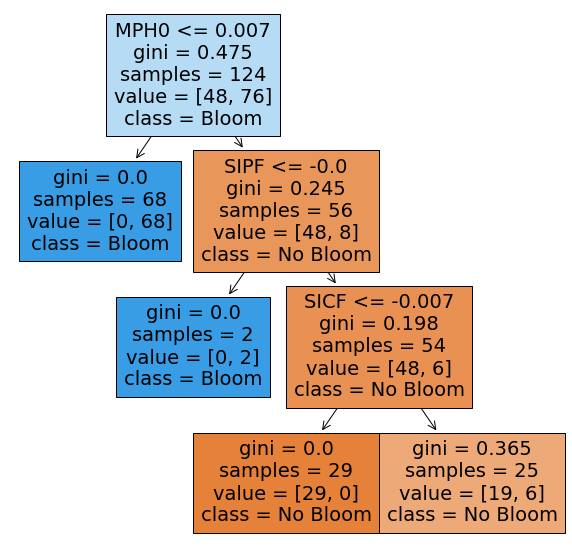

In [16]:
from sklearn import tree

plt.figure(figsize=(10,10))
clf = DecisionTreeClassifier(random_state=0, max_depth=3)
clf.fit(X, y)
tree.plot_tree(clf, 
               feature_names=["NDVI", "BAIR", "SICF", "SIPF", "MPH0", "MPH1", "lambda_max1"],  
               class_names=["No Bloom", "Bloom"],
               filled=True)

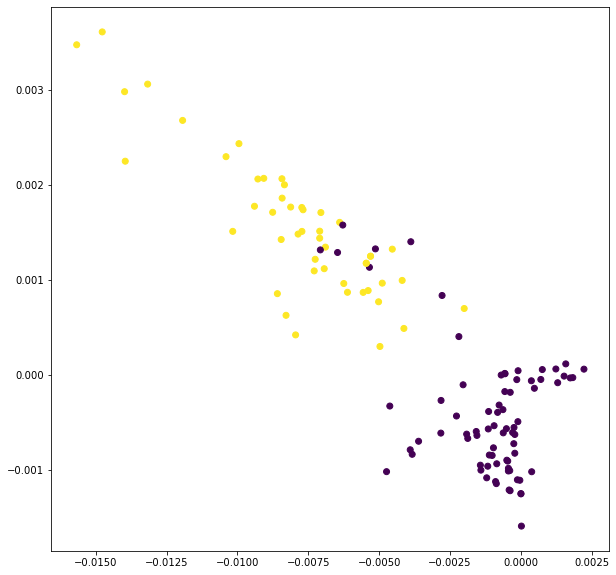

In [19]:
import matplotlib.pyplot as plt

y_binary = np.zeros(y.shape)
for i in range(y_binary.shape[0]):
    if y[i] == "No Bloom":
        y_binary[i] = 0
    else:
        y_binary[i] = 1

plt.figure(figsize=(10,10))
plt.scatter(X[:, 2], X[:, 3], c=y_binary)
plt.show()

### Extend features using climate data

In [34]:
from math import isnan

climate_features = np.zeros((len(dates_list), 3))
climate_features_meta = {"precipitation": {"accumulation_days": 4, "accumulation_type": "sum"},
                         "temperature": {"accumulation_days": 9, "accumulation_type": "max"},
                         "wind": {"accumulation_days": 9, "accumulation_type": "max"}}
for idx, key_value in enumerate(climate_features_meta.items()):
    climate_feature_name = key_value[0]
    feature_metadata = key_value[1]
    feature_accumulated_data = []
    for date_idx, d in enumerate(dates_list):
        row_date = datetime(d.year, d.month, d.day, 0, 0, 0)
        historic_data = dataset.get_historic_data(row_date, feature_metadata["accumulation_days"])

        if len(historic_data) == 0:
            print(f"{d} has no historic data")
            continue

        climate_feature_value = getattr(historic_data[climate_feature_name], feature_metadata["accumulation_type"])()
        if isnan(climate_feature_value):
            print(historic_data[["date", climate_feature_name]])
            climate_feature_value = 0
        feature_accumulated_data.append(climate_feature_value)

    climate_features[:, idx] = np.array(feature_accumulated_data)
    
X_extended = np.hstack((X,climate_features))

## Prediction with MPH indexes and climate data

DecisionTreeClassifier(max_depth=3, random_state=0)
Accuracy: 0.89
Precision: 0.8
Recall: 0.94
FPR: 0.06
FNR: 0.14


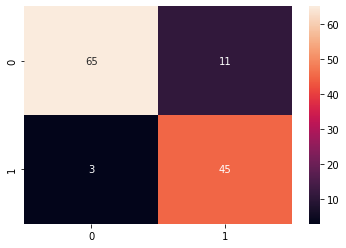

LogisticRegression()
Accuracy: 0.6
Precision: 0.0
Recall: 0.0
FPR: 1.0
FNR: 0.01


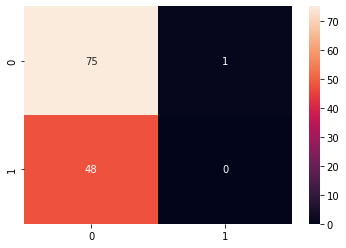

Pipeline(steps=[('standardscaler', StandardScaler()),
                ('svc', SVC(gamma='auto'))])
Accuracy: 0.94
Precision: 0.87
Recall: 0.98
FPR: 0.02
FNR: 0.09


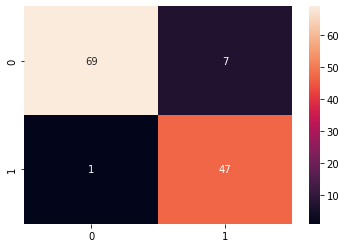

GaussianNB()
Accuracy: 0.9
Precision: 0.8
Recall: 1.0
FPR: 0.0
FNR: 0.16


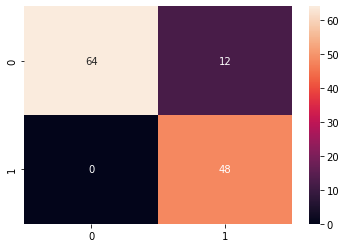

Pipeline(steps=[('standardscaler', StandardScaler()),
                ('sgdclassifier', SGDClassifier())])
Accuracy: 0.89
Precision: 0.87
Recall: 0.83
FPR: 0.17
FNR: 0.08


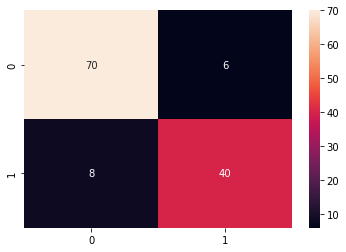

KNeighborsClassifier()
Accuracy: 0.8
Precision: 0.72
Recall: 0.79
FPR: 0.21
FNR: 0.2


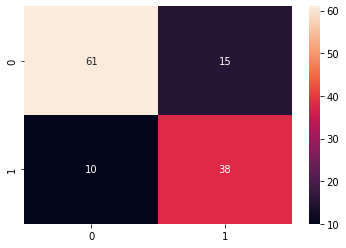

RandomForestClassifier(max_depth=3, random_state=0)
Accuracy: 0.93
Precision: 0.87
Recall: 0.96
FPR: 0.04
FNR: 0.09


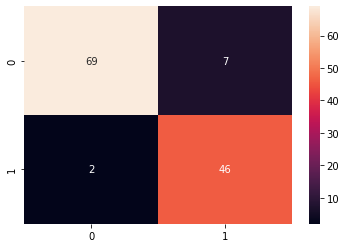

GradientBoostingClassifier(learning_rate=1.0, max_depth=1, random_state=0)
Accuracy: 0.92
Precision: 0.88
Recall: 0.92
FPR: 0.08
FNR: 0.08


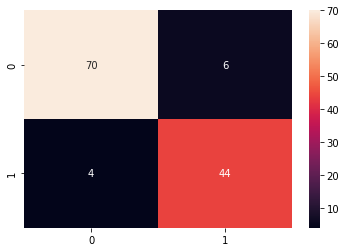

LGBMClassifier()
Accuracy: 0.91
Precision: 0.86
Recall: 0.92
FPR: 0.08
FNR: 0.09


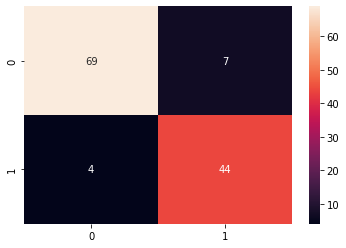

XGBClassifier(base_score=None, booster=None, colsample_bylevel=None,
              colsample_bynode=None, colsample_bytree=None,
              enable_categorical=False, gamma=None, gpu_id=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=None, max_delta_step=None, max_depth=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              n_estimators=100, n_jobs=None, num_parallel_tree=None,
              predictor=None, random_state=None, reg_alpha=None,
              reg_lambda=None, scale_pos_weight=None, subsample=None,
              tree_method=None, validate_parameters=None, verbosity=0)


/home/enzo/anaconda3/envs/cyano_venv/lib/python3.6/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


Accuracy: 0.91
Precision: 0.86
Recall: 0.92
FPR: 0.08
FNR: 0.09


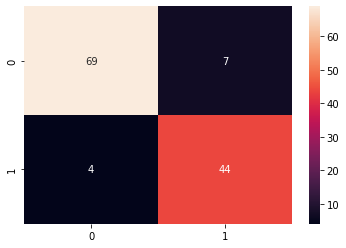

In [35]:
clfs = [DecisionTreeClassifier(random_state=0, max_depth=3),
        LogisticRegression(),
        make_pipeline(StandardScaler(), SVC(gamma='auto')),
        GaussianNB(),
        make_pipeline(StandardScaler(), SGDClassifier(max_iter=1000, tol=1e-3)),
        KNeighborsClassifier(n_neighbors=5),
        RandomForestClassifier(max_depth=3, random_state=0),
        GradientBoostingClassifier(n_estimators=100, learning_rate=1.0, max_depth=1, random_state=0),
        LGBMClassifier(),
        XGBClassifier(verbosity=0)]
        

    
#cv = StratifiedKFold(n_splits=2)
cv = LeaveOneOut()
for clf in clfs:
    print(clf)
    y_test_all = []
    y_pred_all = []
    for train_index, test_index in cv.split(X_extended, y):
        X_train, X_test = X[train_index], X[test_index]
        y_train, y_test = y[train_index], y[test_index]

        clf.fit(X_train, y_train)

        y_pred = clf.predict(X_test)

        y_test_all.append(y_test[0])
        y_pred_all.append(y_pred[0])

    #     m = metrics(y_test, y_pred)
    #     print("Accuracy:", m["accuracy"])
    #     print("Precision:", m["precision"])
    #     print("Recall:", m["recall"])
    #     print("FPR:", m["false positive rate"])
    #     print("FNR:", m["false negative rate"])
    #     sns.heatmap(m["confusion matrix"], annot=True)
    #     plt.show()

    m = metrics(y_test_all, y_pred_all)
    print("Accuracy:", m["accuracy"])
    print("Precision:", m["precision"])
    print("Recall:", m["recall"])
    print("FPR:", m["false positive rate"])
    print("FNR:", m["false negative rate"])
    sns.heatmap(m["confusion matrix"], annot=True)
    plt.show()

### Train and save model

In [52]:
#filename = 'gaussianNB_model.sav'
filename = 'svc_model.sav'

In [58]:
from sklearn.svm import SVC
from sklearn.naive_bayes import GaussianNB

from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler

import pickle

#model = GaussianNB()
model = make_pipeline(StandardScaler(), SVC(gamma='auto'))

model.fit(X, y)

print(model.score(X, y))
# save the model to disk
pickle.dump(model, open(filename, 'wb'))

0.9435483870967742


### load the model from disk

In [63]:
loaded_model = pickle.load(open(filename, 'rb'))
result = loaded_model.score(X, y)
print(result)

0.9435483870967742


## Predictions on unseen data

### Trained model

2022-12-05 13:01:19
SAUCE NORTE
SVC model output: No Bloom
MPH output:Bloom
SAUCE SUR
SVC model output: No Bloom
MPH output:Bloom
OSE
SVC model output: No Bloom
MPH output:Bloom
--------------------
2022-12-06 12:35:08
SAUCE NORTE
SVC model output: Bloom
MPH output:Bloom
SAUCE SUR
SVC model output: No Bloom
MPH output:No Bloom
OSE
SVC model output: No Bloom
MPH output:Bloom
--------------------
2022-12-06 13:14:11
SAUCE NORTE
SVC model output: Bloom
MPH output:Bloom
SAUCE SUR
SVC model output: No Bloom
MPH output:Bloom
OSE
SVC model output: No Bloom
MPH output:Bloom
--------------------
2022-12-07 12:47:59
SAUCE NORTE
SVC model output: Bloom
MPH output:Bloom
SAUCE SUR
SVC model output: Bloom
MPH output:Bloom
OSE
SVC model output: Bloom
MPH output:Bloom
--------------------
2022-12-09 12:57:34
SAUCE NORTE
SVC model output: Bloom
MPH output:Bloom
SAUCE SUR
SVC model output: Bloom
MPH output:Bloom
OSE
SVC model output: Bloom
MPH output:Bloom
--------------------
2022-12-11 12:44:16
SAUCE 

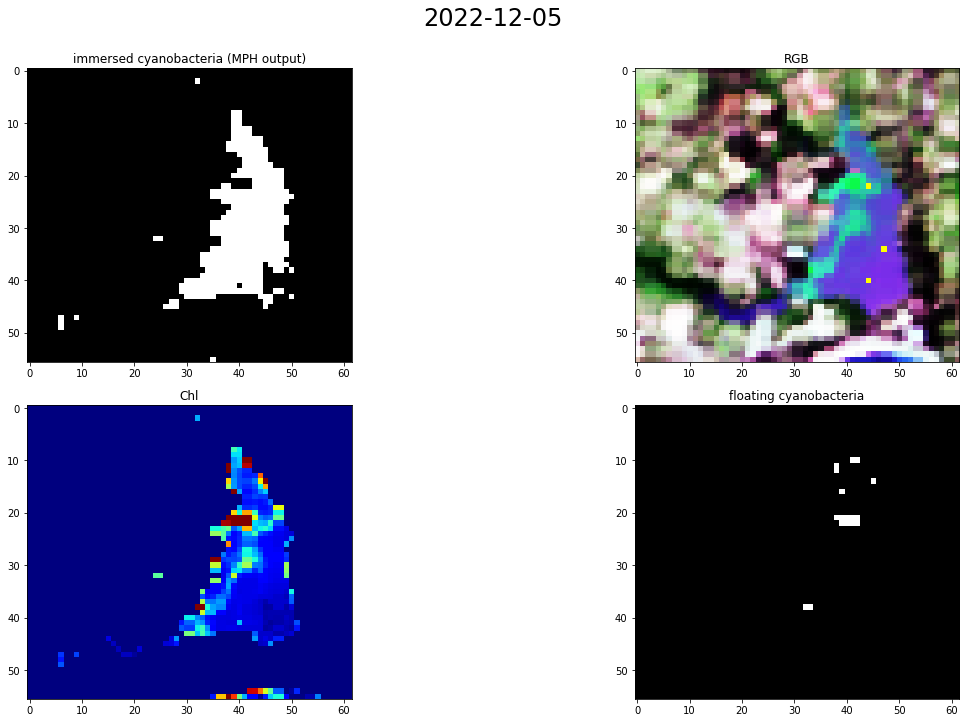

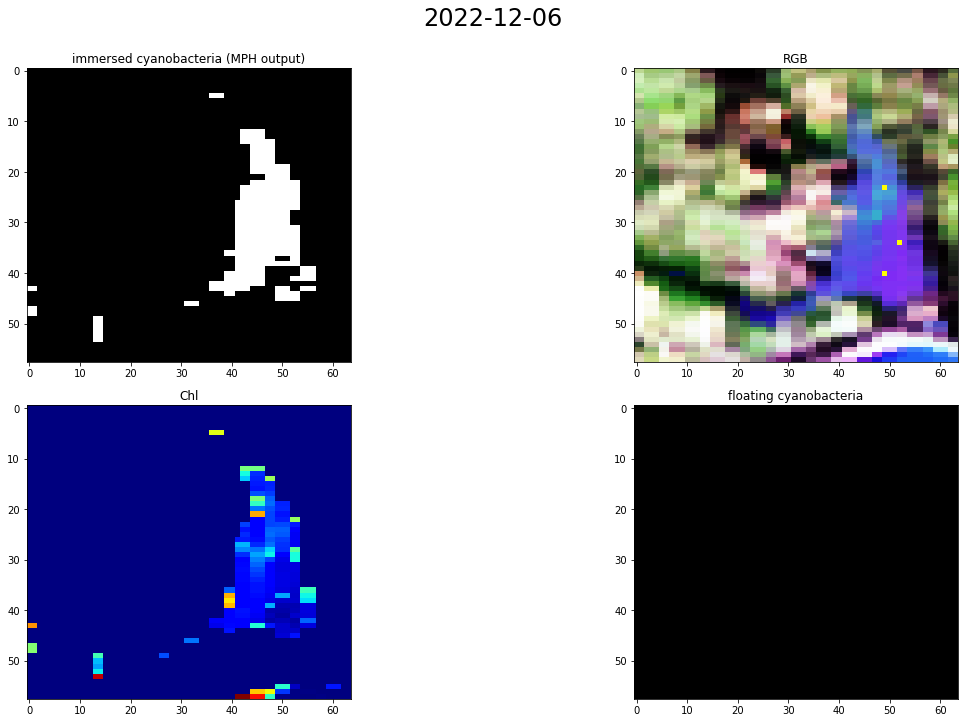

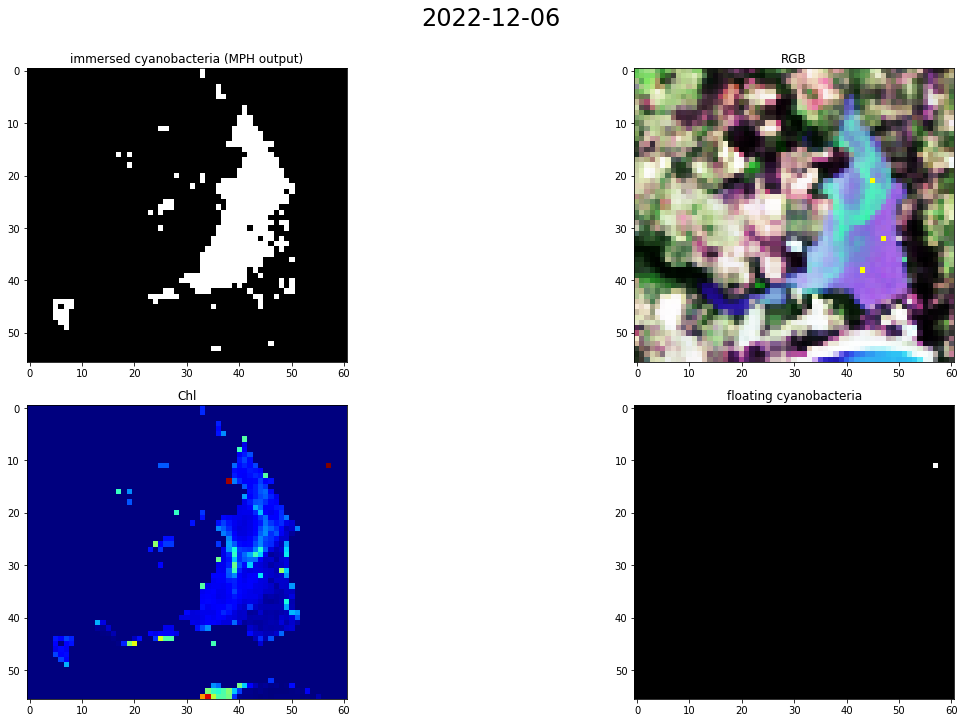

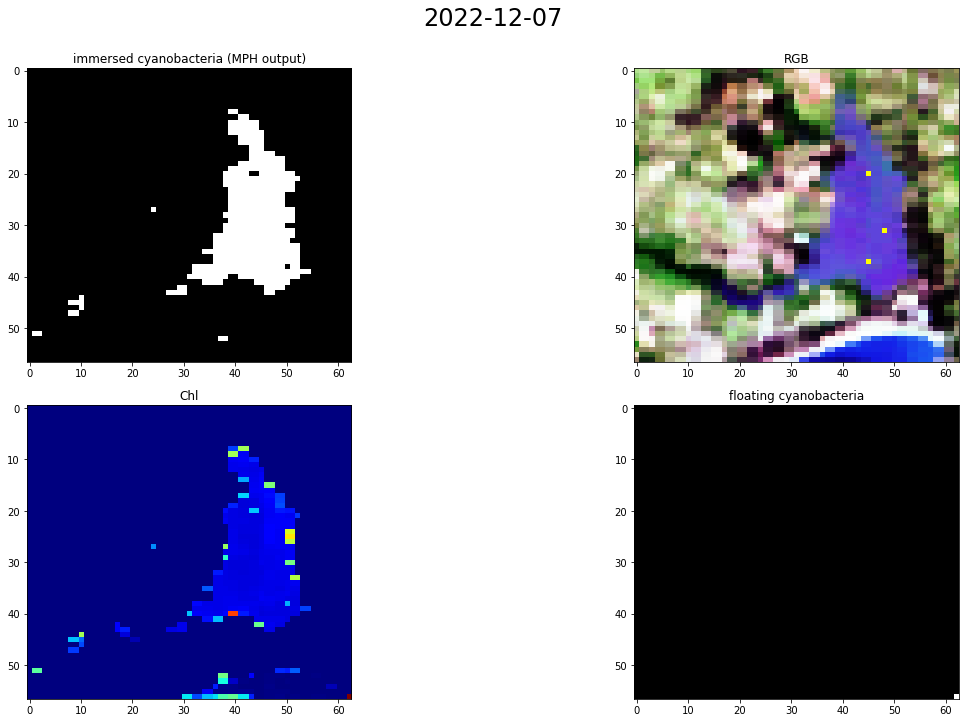

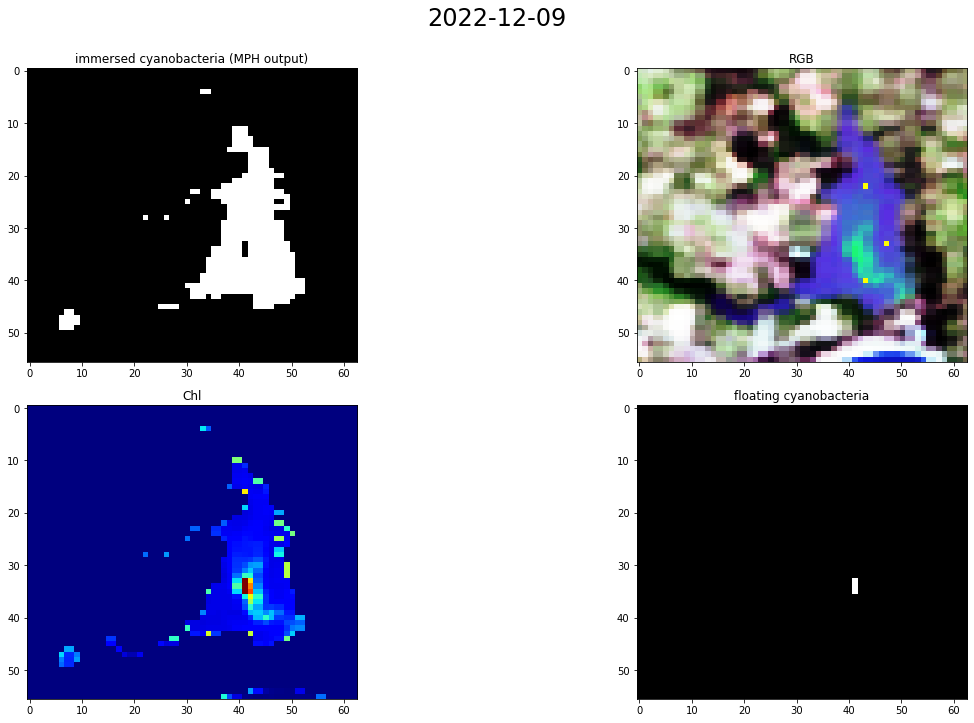

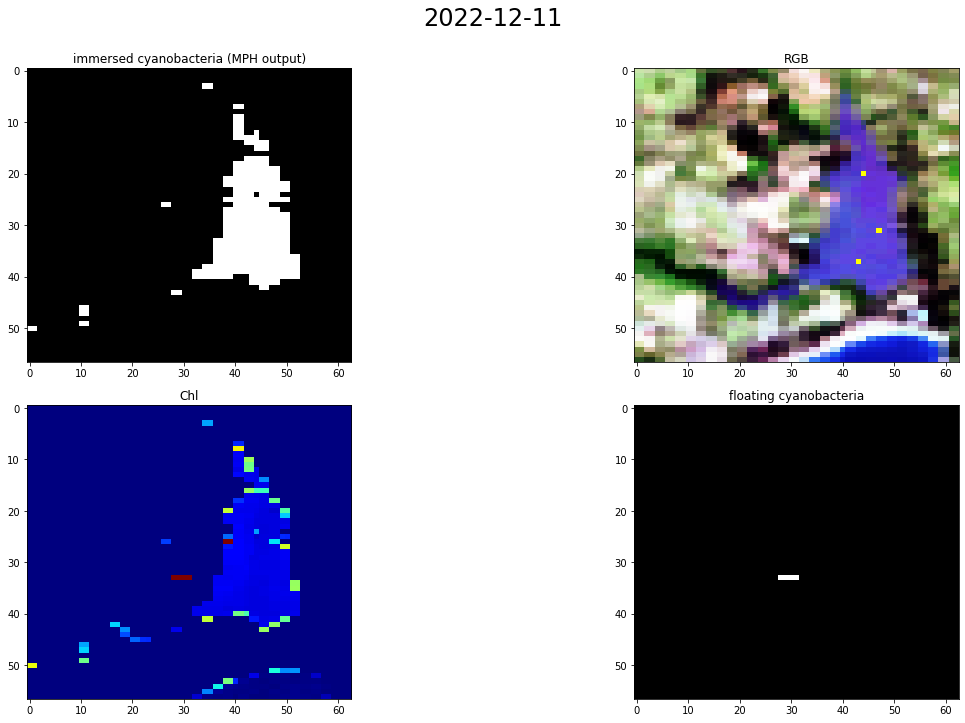

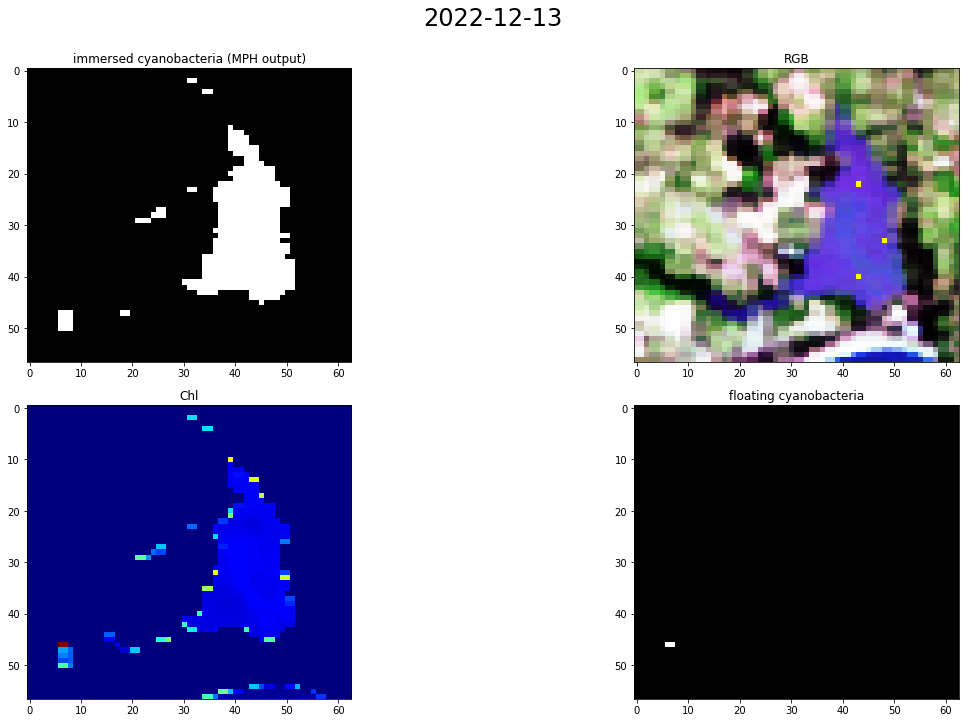

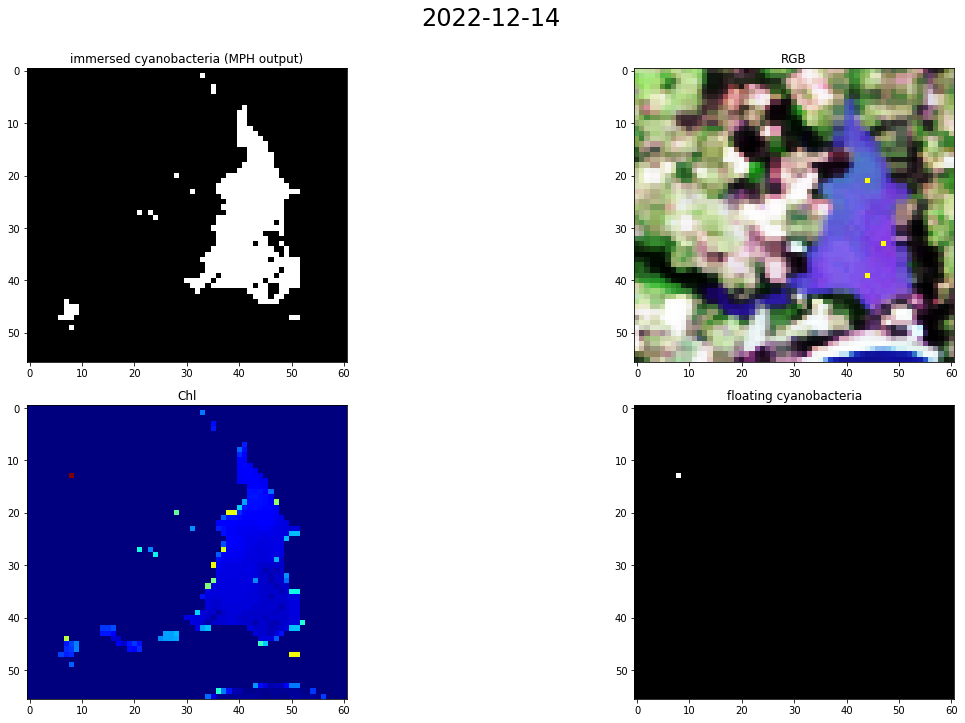

In [65]:
import cv2
import os

new_data_generator = OLCIdataGenerator(processed_data_path, DATE_FORMAT, skip_invalid=True, 
                                      start_date="2022-12-01", end_date="2022-12-20")

sampling_points_coords = {"SAUCE NORTE": [-34.799398, -55.047355],
                          "SAUCE SUR": [-34.843127, -55.064624],
                          "OSE": [-34.829670, -55.048758]}

save_directory = "/home/enzo/Cyano_Detection/data/final/december_2022"

for olci_data in new_data_generator:
    olci_data.create_sparse_mask([c for c in sampling_points_coords.values()])
    print(olci_data.date)
    fig2 = plt.figure(figsize=(20,10))
    
    fig2.add_subplot(221).title.set_text("immersed cyanobacteria (MPH output)")
    plt.imshow(olci_data.mph.immersed_cyanobacteria, cmap="gray")
    
    fig2.add_subplot(222).title.set_text("RGB")
    #day.paint_coords(CONTROL_COORDS, [255, 119, 255])
    for location_name, location_coords in sampling_points_coords.items():
        print(location_name)
        i, j = olci_data.get_pos_index(location_coords[0], location_coords[1])
        
        #get a 3x3 grid centered on the sampling location
        NDVI = olci_data.mph.NDVI[i-1:i+2, j-1:j+2].mean()
        BAIR = olci_data.mph.BAIR[i-1:i+2, j-1:j+2].mean()
        SICF = olci_data.mph.SICF[i-1:i+2, j-1:j+2].mean()
        SIPF = olci_data.mph.SIPF[i-1:i+2, j-1:j+2].mean()
        MPH0 = olci_data.mph.MPH0[i-1:i+2, j-1:j+2].mean()
        MPH1 = olci_data.mph.MPH1[i-1:i+2, j-1:j+2].mean()
        lambda_max1 = olci_data.mph.lambda_max1[i-1:i+2, j-1:j+2].max()

        model_input = np.array([NDVI, BAIR, SICF, SIPF, MPH0, MPH1, lambda_max1])
        
        model_output = loaded_model.predict(model_input.reshape(1, -1))[0]
        print(f"SVC model output: {model_output}")
        olci_data.paint_coords([location_coords], [255, 255, 0])
        
        olci_data.create_sparse_mask([sampling_points_coords[location_name]])
        
        immersed_mask = olci_data.mph.immersed_cyanobacteria*olci_data.mask
        count_immersed = np.count_nonzero(immersed_mask)
        
        floating_mask = olci_data.mph.floating_cyanobacteria*olci_data.mask
        count_floating = np.count_nonzero(olci_data.mph.floating_cyanobacteria*olci_data.mask)
        
        count_total = count_immersed + count_floating

        MPH_pred = "Bloom" if count_total > 0 else "No Bloom"
        print(f"MPH output:{MPH_pred}")
        
        
    plt.imshow(olci_data.rgb)
    
    fig2.add_subplot(223).title.set_text("Chl")
    plt.imshow(olci_data.mph.chl, cmap='jet', interpolation='none',
              vmin=0, vmax=350)
    
    fig2.add_subplot(224).title.set_text("floating cyanobacteria")
    plt.imshow(olci_data.mph.floating_cyanobacteria, cmap="gray")
    
    fig2.suptitle(str(olci_data.date.date()), fontsize=24, y=1)
    fig2.tight_layout()
    
    #plt.savefig(os.path.join(save_directory, str(olci_data.date.date())))
    print("--------------------")